In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import os
import tensorflow as tf
from IPython import display
from sklearn import metrics
import glob
import sys
from riotwatcher import RiotWatcher
import requests

api_file = os.path.join('..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

tf.logging.set_verbosity(tf.logging.ERROR)

/Users/bailey/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [3]:
def _parse_function(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "targets": tf.FixedLenFeature(shape=[1], dtype=tf.int64)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    blue_champs = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    red_champs = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    blue_win = parsed_features['targets']

    return  {'blue_champs':blue_champs, 'red_champs':red_champs}, blue_win

#### Check the parse function worked

In [4]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('dota2_training_data','dota2_training_data.tfrecords'))
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<MapDataset shapes: ({radiant_heroes: (?,), dire_heroes: (?,)}, (1,)), types: ({radiant_heroes: tf.int64, dire_heroes: tf.int64}, tf.int64)>

In [5]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'dire_heroes': array([ 96,  95,  50,  26, 121]),
  'radiant_heroes': array([14, 87, 28, 59, 54])},
 array([1]))

## Model Functions

In [6]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True, batch_size=50):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(batch_size, ds.output_shapes)
  
    ds = ds.repeat(num_epochs)
  
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Linear model with explicit vocabulary (all heroes)

In [24]:
def construct_hero_categorical_columns(keys):
    """Construct categorical features for all features
        Args: 
            input_features: names of input feature columns to use
        returns:
            a set of categorical columns
    """
    vocab = list(range(105))+list(range(106,114))+list(range(119,121))
    return set([tf.feature_column.categorical_column_with_vocabulary_list(key,
                                                                     vocabulary_list = vocab,
                                                                     num_oov_buckets =0)
                                    for key in keys])
                                                               

## Define and train the linear model

In [8]:
def train_linear_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_file,
    test_file):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `LinearClassifier` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
      )
  
    training_input_fn =lambda: _input_fn([training_file])
    test_input_fn =lambda: _input_fn([test_file])

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = linear_classifier.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(1-evaluation_metrics['accuracy'])
                            
        evaluation_metrics = linear_classifier.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(1-evaluation_metrics['accuracy'])
        
        print('test inaccuracy', 1-evaluation_metrics['accuracy'])

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training inaccuracy')
    plt.plot(test_acc,label='Test inaccuracy')
    plt.plot(1-evaluation_metrics['accuracy_baseline']*np.ones(periods))
    plt.legend()
    plt.show()
    
    return linear_classifier


Training model...
test inaccuracy 0.417261004447937
test inaccuracy 0.41385525465011597
test inaccuracy 0.4117717742919922
test inaccuracy 0.4117317199707031
test inaccuracy 0.4105697274208069
test inaccuracy 0.41012901067733765
test inaccuracy 0.411491334438324
test inaccuracy 0.40992867946624756
test inaccuracy 0.4095280170440674
test inaccuracy 0.410930335521698
test inaccuracy 0.4117317199707031
test inaccuracy 0.4120522737503052
test inaccuracy 0.41201215982437134
test inaccuracy 0.41257309913635254
test inaccuracy 0.41237276792526245
test inaccuracy 0.41349464654922485
test inaccuracy 0.41225260496139526
test inaccuracy 0.41413575410842896
test inaccuracy 0.414015531539917
test inaccuracy 0.4138953685760498
Test set metrics:
accuracy 0.58610463
accuracy_baseline 0.5561343
auc 0.60473657
auc_precision_recall 0.64421403
average_loss 0.66975176
label/mean 0.5561343
loss 33.431328
precision 0.6007378
prediction/mean 0.55641973
recall 0.76260805
global_step 10000
---


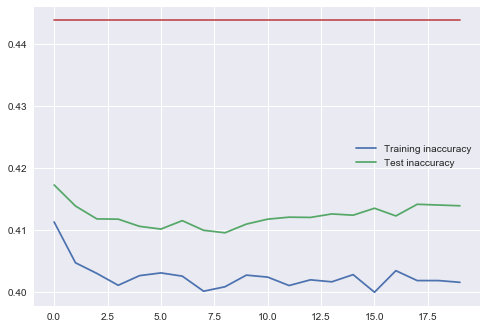

In [9]:
training_file = os.path.join('dota2_training_data','dota2_training_data.tfrecords')
test_file = os.path.join('dota2_test_data', 'dota2_test_data.tfrecords')

trained_linear_model = train_linear_model(
    learning_rate=0.03,
    steps=10000,
    batch_size=1000,
    feature_columns=construct_hero_categorical_columns(['radiant_heroes','dire_heroes']),
    training_file=training_file,
    test_file=test_file)

## Define and train a DNN model

### Define feature column constructor functions

In [10]:
def construct_indicator_columns(feature_columns):
    """Construct indicator columns for all features
            from categorical columns
        Args: 
            feature_columns: Set of 'tf.feature_column.categorical_column'
                to convert to indicator columns
        returns:
            a list of indicator columns
    """
    indicator_columns = []
    for column in list(feature_columns):
        indicator_columns.append(tf.feature_column.indicator_column(column))
        
    return indicator_columns
        

In [11]:
def construct_embedding_columns(feature_columns, dimension):
    """Construct embedding columns for all features
            from categorical columns
        Args:
            feature_columns: `Set` of 'tf.feature_column.categorical_column'
                to convert to embedding columns
            dimension: `int` that shows the 
        returns:
            a list of embedding columns
    """
            
    embedding_columns = []
    for column in list(feature_columns):
        embedding_columns.append(tf.feature_column.embedding_column(column,dimension=dimension))
        
    return embedding_columns

### Define model training function

In [76]:
def train_dnn_model(
    my_optimizer,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_file,
    test_file):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        hidden_units: A `list` of `ints` specifying the number of layers and number 
            of nodes per layer.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a dnn regressor object.
    dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
        )
  
    training_input_fn =lambda: _input_fn([training_file],batch_size=batch_size)
    test_input_fn =lambda: _input_fn([test_file],batch_size=batch_size)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(1-evaluation_metrics['accuracy'])
        print('training inaccuracy %f' %(1-evaluation_metrics['accuracy'])) 
        
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(1-evaluation_metrics['accuracy'])
        
        print('test inaccuracy %f' %(1-evaluation_metrics['accuracy']))

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training inaccuracy')
    plt.plot(test_acc,label='Test inaccuracy')
    plt.plot(1-evaluation_metrics['accuracy_baseline']*np.ones(periods))
    plt.legend()
    plt.show()
    
    return dnn_classifier


### Specify path to tfrecord files and construct feature colums

In [61]:
training_file = os.path.join('dota2_training_data','dota2_training_data.tfrecords')
test_file = os.path.join('dota2_test_data', 'dota2_test_data.tfrecords')

categorical_feature_columns = construct_hero_categorical_columns(['radiant_heroes','dire_heroes'])
indicator_feature_columns = construct_indicator_columns(categorical_feature_columns)
embedding_feature_columns = construct_embedding_columns(categorical_feature_columns,dimension=4)

### Train model

Training model...
training inaccuracy 0.448000
test inaccuracy 0.443542
training inaccuracy 0.413900
test inaccuracy 0.418276
training inaccuracy 0.411700
test inaccuracy 0.419083
training inaccuracy 0.406300
test inaccuracy 0.417318
training inaccuracy 0.401050
test inaccuracy 0.422714
training inaccuracy 0.401750
test inaccuracy 0.415603
training inaccuracy 0.402100
test inaccuracy 0.421655
training inaccuracy 0.402600
test inaccuracy 0.416259
training inaccuracy 0.404400
test inaccuracy 0.416057
training inaccuracy 0.399000
test inaccuracy 0.418276
training inaccuracy 0.401850
test inaccuracy 0.416007
training inaccuracy 0.409250
test inaccuracy 0.418781
training inaccuracy 0.401800
test inaccuracy 0.417570
training inaccuracy 0.399950
test inaccuracy 0.422008
training inaccuracy 0.399850
test inaccuracy 0.417621
training inaccuracy 0.400850
test inaccuracy 0.413990
training inaccuracy 0.397200
test inaccuracy 0.417217
training inaccuracy 0.397050
test inaccuracy 0.416713
training i

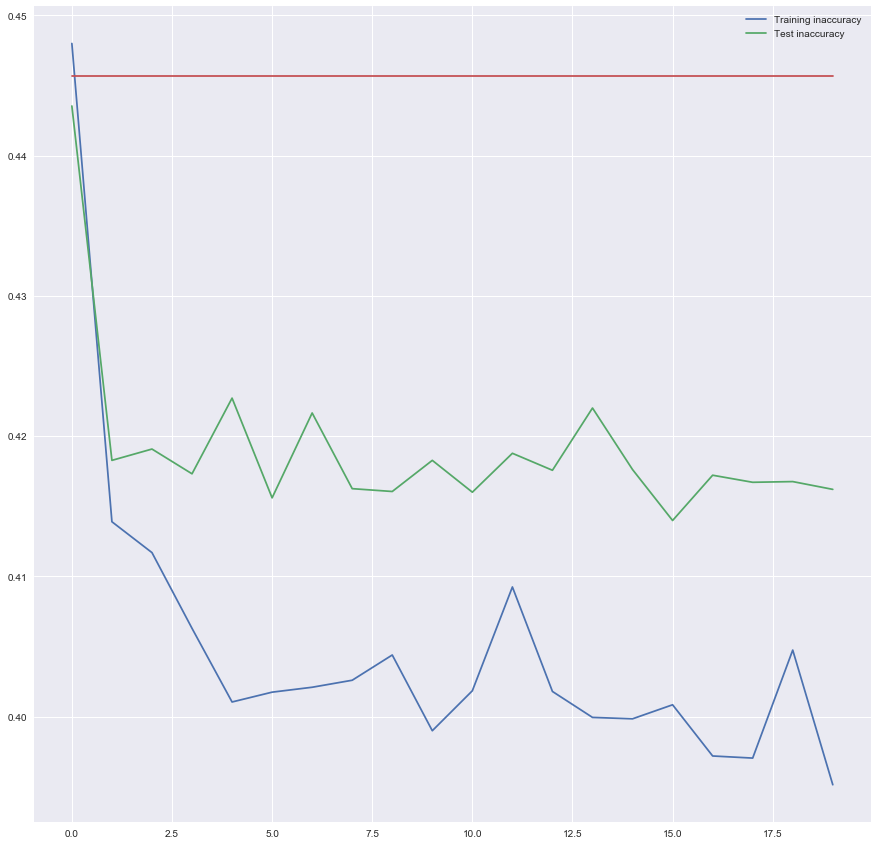

In [78]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0024, learning_rate=0.015)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

trained_dnn_model = train_dnn_model(
    my_optimizer = my_optimizer,
    hidden_units = [4,4],
    steps=2000,
    batch_size=200,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    test_file=test_file)

### Validate model
only do this if you're done training!!

In [43]:
validation_file = os.path.join('dota2_validation_data', 'dota2_validation_data.tfrecords')
validation_input_fn =lambda: _input_fn([validation_file])
evaluation_metrics = trained_dnn_model.evaluate(
            input_fn=validation_input_fn,
            steps=100)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.59
accuracy_baseline 0.5532
auc 0.59637433
auc_precision_recall 0.63425905
average_loss 0.6738959
label/mean 0.5532
loss 33.694794
precision 0.60888076
prediction/mean 0.548346
recall 0.72378886
global_step 1000


### Investigate embeding layer

In [79]:
hero_list = interface('IEconDOTA2_570').GetHeroes(itemizedonly = True)['result']['heroes']

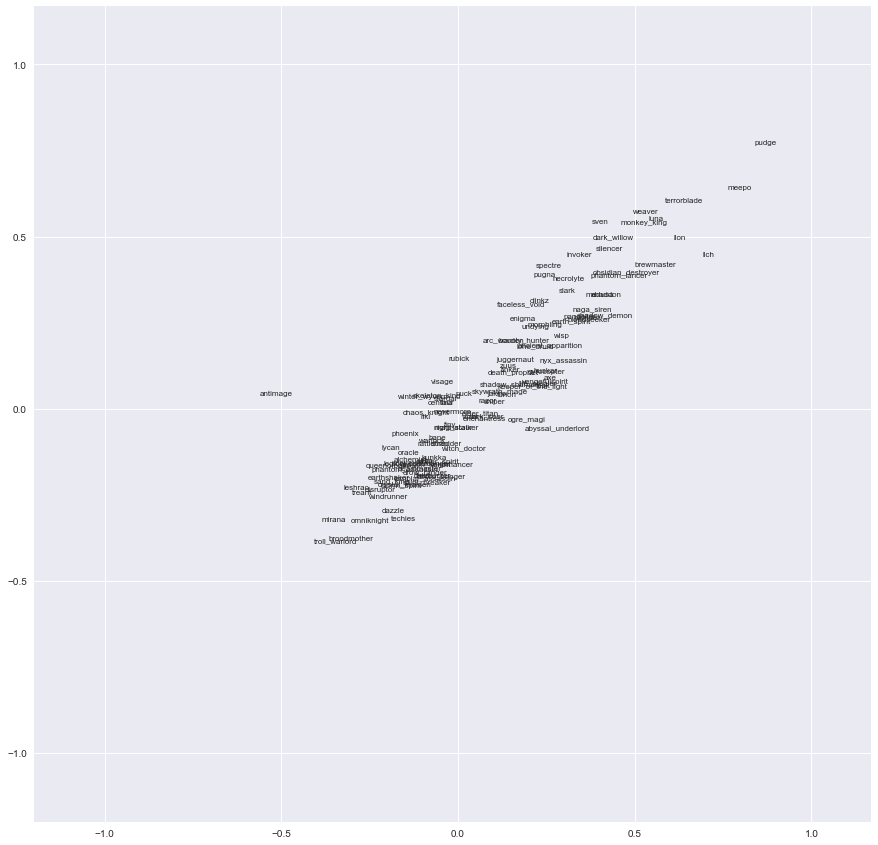

In [85]:
vocab = list(range(105))+list(range(106,114))+list(range(119,121))
dire_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/dire_heroes_embedding/embedding_weights')

radiant_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/radiant_heroes_embedding/embedding_weights')

for hero_index in range(len(vocab)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    dire_vector = np.zeros(len(vocab))
    dire_vector[hero_index] = 1
    radiant_vector = np.zeros(len(vocab))
    radiant_vector[hero_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    dire_embedding_xy = np.matmul(dire_vector, dire_embedding_matrix)
    radiant_embedding_xy = np.matmul(dire_vector,dire_embedding_matrix)
    #plt.text(dire_embedding_xy[0],
    #       dire_embedding_xy[1],
    #       hero_list[hero_index]['name'][14:],fontsize=8)
    plt.text(radiant_embedding_xy[0],
           radiant_embedding_xy[3],
           hero_list[hero_index]['name'][14:],fontsize=8,)

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * dire_embedding_matrix.min(), 1.2 * dire_embedding_matrix.max())
plt.ylim(1.2 * dire_embedding_matrix.min(), 1.2 * dire_embedding_matrix.max())
plt.show() 

# Preprocessing, input functions, and linear training for DataFrame data format

## Preprocess functions for input without TFRecords format

In [46]:
#Split training and validation datasets with a given training fraction. 

#to begin with we have a sample of 7050 matches to validation the model with.
#This may not be enough games to accurately determine win probability but probably good enough for first validations

training_fraction = 0.7
head_num = int(training_fraction * len(dota2_df))
tail_num = len(dota2_df)-head_num

training_examples = preprocess_features(dota2_df.head(head_num))
training_targets = preprocess_targets(dota2_df.head(head_num))

validation_examples = preprocess_features(dota2_df.tail(tail_num))
validation_targets = preprocess_targets(dota2_df.tail(tail_num))

#print("Training features summary")
#training_examples.style
print("\nTraining targets summary")
display.display(training_targets.describe())

#print("\nvalidation feature summary")
#validation_examples.style
print("\nvalidation target summary")
display.display(validation_targets.describe())


Training targets summary


,radiant_win
count,6157.000000
mean,0.549943
std,0.497540
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000



validation target summary


,radiant_win
count,2640.000000
mean,0.549242
std,0.497664
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [3]:
def preprocess_features(dota2_df):
    """Take dota2_df and create a dataframe containing only the features for our model
            Args: 
                dota2_df: Dataframe containing dota2 training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of heroes for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['radiant_heroes'] = list(np.array(dota2_df.loc[:,['radiant_heroes0',
                                                'radiant_heroes1','radiant_heroes2',
                                                'radiant_heroes3','radiant_heroes4']]))
    processed_df['dire_heroes'] = list(np.array(dota2_df.loc[:,['dire_heroes0',
                                    'dire_heroes1','dire_heroes2',
                                    'dire_heroes3','dire_heroes4']]))
    
    ##only features (to start with) are the heroes in the game
    #processed_df = dota2_df[['radiant_heroes0', 'radiant_heroes1',
    #                   'radiant_heroes2', 'radiant_heroes3', 'radiant_heroes4',
    #                    'dire_heroes0', 'dire_heroes1', 'dire_heroes2',
    #                    'dire_heroes3', 'dire_heroes4']]
    
    ##create two synthetic features that is the product of all heroes for each team
    #processed_df['radiant_hero_product'] = dota2_df['radiant_heroes0']*dota2_df['radiant_heroes1']*dota2_df['radiant_heroes2']dota2_df['radiant_heroes3']*dota2_df['radiant_heroes4']
    #processed_df['dire_hero_product'] = dota2_df['dire_heroes0']*dota2_df['dire_heroes1']*dota2_df['dire_heroes2']dota2_df['dire_heroes3']*dota2_df['dire_heroes4']
    
    return processed_df
    
def preprocess_targets(dota2_df):
    """Take dota2_df and create a dataframe containing only the targets for our model
            Args: 
                dota2_df: Dataframe containing dota2 training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['radiant_win'] = dota2_df['radiant_win']
    
    return target_df

## Build Functions for doing linear classifier modelling without TFRecords

In [77]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a logistic regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = tf.data.Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### DNN model training 

In [86]:
def train_dnn_model(
    learning_rate,
    regularization,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        l1_regularization: A `float`, the L1 regularization rate. This regularizatin 
          penalizes non-zero weights in the model to prevent overfitting as well as
          save memory.
        l2_regularization: A `float`, the L2 regularization rate. This regularization
          penalizes large weights in the model to prevent overfitting.
        hidden_units: A list of `ints`, the number of nodes in each layer for the DNN
          model.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
      )
  
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["radiant_win"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["radiant_win"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
            )
        # Take a break and compute predictions.
        training_predictions = dnn_classifier.predict(input_fn=predict_training_input_fn)
    
    print("Model training finished.")


    return dnn_classifier

In [ ]:
trained_linear_model = train_dnn_model(
    learning_rate=0.07,
    regularization=0.01
    steps=1000,
    batch_size=100,
    feature_columns=construct_hero_categorical_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets)